In [1]:
import numpy as np
import pickle
import torch

# Get the interactive Tools for Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 6]

In [2]:
class Vocabulary(object):
    def __init__(self, pad_token='<pad>', unk_token='<unk>', eos_token='<eos>'):
        self.token2idx = {}
        self.idx2token = []
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.eos_token = eos_token
        if pad_token is not None:
            self.pad_index = self.add_token(pad_token)
        if unk_token is not None:
            self.unk_index = self.add_token(unk_token)
        if eos_token is not None:
            self.eos_index = self.add_token(eos_token)

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def get_index(self, token):
        if isinstance(token, str):
            return self.token2idx.get(token, self.unk_index)
        else:
            return [self.token2idx.get(t, self.unk_index) for t in token]

    def get_token(self, index):
        return self.idx2token[index]

    def __len__(self):
        return len(self.idx2token)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

We will use the vocabulary computed by the Text Preprocessing notebook (text-preprocessing), and the word vectors computed by the CBOW Training notebook (cbow-vectors)

In [3]:
DATASET_VERSION = 'ca-100'
CBOW_VOCABULARY_ROOT = f'../input/text-preprocessing/data/{DATASET_VERSION}'
CBOW_VECTORS_ROOT = f'../input/cbow-training/data/{DATASET_VERSION}'

In [4]:
dict = f'{CBOW_VOCABULARY_ROOT}/ca.wiki.train.tokens.nopunct.dic'
counter = pickle.load(open(dict, 'rb'))
words, values = zip(*counter.most_common(5000))
print('Most frequent Catalan words')
print(words[:10])
print(values[:10])

Most frequent Catalan words
('de', 'la', 'i', 'a', 'el', 'd', 'l', 'que', 'en', 'va')
(5029788, 2771563, 2495802, 2130330, 1704858, 1362665, 1322822, 1293716, 1266356, 1191615)


In [5]:
from scipy.stats import entropy
h = entropy(values)
print(f'Word entropy: {h:5.2f}, Perplexity: {np.exp(h):5.0f}')
print(f'Probability of the most frequent word: {values[0]/sum(values):2.3f}')

Word entropy:  6.22, Perplexity:   505
Probability of the most frequent word: 0.076


**Zipf's law of words**. Zipf's law was originally formulated in terms of quantitative linguistics, stating that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.

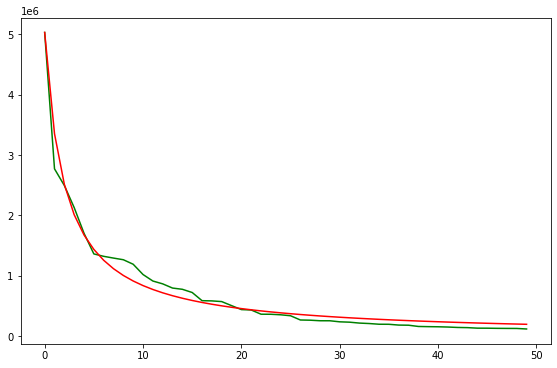

In [6]:
_ = plt.plot(values[:50], 'g', 2*values[0]/np.arange(2,52), 'r')

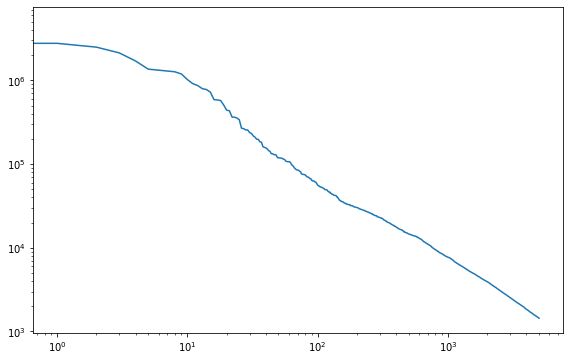

In [7]:
_ = plt.loglog(values)
plt.show()

**Benford's law**, also called the Newcomb–Benford law, the law of anomalous numbers, or the first-digit law, is an observation about the frequency distribution of leading digits in many real-life sets of numerical data.

Counter({1: 1705, 2: 1332, 3: 673, 4: 450, 5: 283, 6: 192, 7: 157, 8: 126, 9: 82})


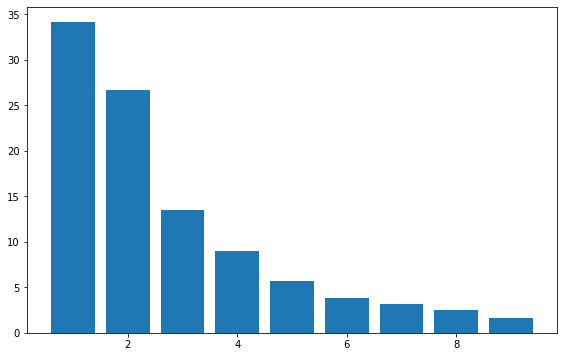

In [8]:
from collections import Counter
benford = Counter(int(str(item[1])[0]) for item in counter.most_common(5000))
print(benford)
percentage = np.array(list(benford.values()), dtype=float)
percentage /= percentage.sum()
_ = plt.bar(list(benford.keys()), percentage*100)

In [9]:
modelname = f'{CBOW_VECTORS_ROOT}/{DATASET_VERSION}.pt'
state_dict = torch.load(modelname, map_location=torch.device('cpu'))

In [10]:
state_dict.keys()

odict_keys(['emb.weight', 'lin.weight'])

In [11]:
input_word_vectors = state_dict['emb.weight'].numpy()
input_word_vectors.shape

(100002, 100)

In [12]:
output_word_vectors = state_dict['lin.weight'].numpy()
output_word_vectors.shape

(100002, 100)

In [13]:
token_vocab = Vocabulary()
token_vocab.load(f'{CBOW_VOCABULARY_ROOT}/ca.wiki.vocab')

In [14]:
from numpy.linalg import norm
class WordVectors:
    def __init__(self, vectors, vocabulary):
        self.vectors = vectors
        self.vocabulary = vocabulary
    
    def most_similar(self, word, topn=10):
        pad_idx = self.vocabulary.get_index('<pad>')
        idx = self.vocabulary.get_index(word)
        top_w = {}
        v_idx = self.vectors[idx]
        for i in range(len(self.vectors)):
            if i != idx and i != pad_idx:
                v_i = self.vectors[i]
                top_w[self.vocabulary.get_token(i)] = np.dot(v_idx, v_i) / (norm(v_idx)*norm(v_i))   
        sorted_top_w = {k: v for k, v in sorted(top_w.items(), key=lambda item: item[1], reverse=True)}
        top_n = {topn: sorted_top_w[topn] for topn in list(sorted_top_w.keys())[:topn]}
        return 
    
    def analogy(self, x1, x2, y1, topn=5, keep_all=False):
        # If keep_all is False we remove the input words (x1, x2, y1) from the returned closed words
        pad_idx = self.vocabulary.get_index('<pad>')
        idx_x1 = self.vocabulary.get_index(x1)
        idx_x2 = self.vocabulary.get_index(x2)
        idx_y1 = self.vocabulary.get_index(y1)
        
        result_vector = self.vectors[idx_y1] + (self.vectors[idx_x2] - self.vectors[idx_x1])
        top_w = {}
        if keep_all:  
            for i in range(len(self.vectors)):
                if i != pad_idx:
                    v_i = self.vectors[i]
                    top_w[self.vocabulary.get_token(i)] = np.dot(result_vector, v_i) / (norm(result_vector)*norm(v_i))   
        else:
            for i in range(len(self.vectors)):
                if i != idx_x1 and i != idx_x2 and i != idx_y1 and i != pad_idx:
                    v_i = self.vectors[i]
                    top_w[self.vocabulary.get_token(i)] = np.dot(result_vector, v_i) / (norm(result_vector)*norm(v_i))   
        sorted_top_w = {k: v for k, v in sorted(top_w.items(), key=lambda item: item[1], reverse=True)}
        top_n = {topn: sorted_top_w[topn] for topn in list(sorted_top_w.keys())[:topn]}
        return top_n

In [15]:
model1 = WordVectors(input_word_vectors, token_vocab)
model2 = WordVectors(output_word_vectors, token_vocab)

In [16]:
model1.most_similar('català') 

{'valencià': 0.83145213,
 'basc': 0.7595478,
 'mallorquí': 0.70459396,
 'gallec': 0.69547755,
 'espanyol': 0.6659015,
 'andalús': 0.6409342,
 'aragonès': 0.6233479,
 'francès': 0.602529,
 'navarrès': 0.5803894,
 'asturià': 0.5787753}

In [22]:
model1.analogy('home', 'conductor', 'dona')

{'càmera': 0.4865464,
 'parada': 0.46596307,
 'vàlvula': 0.45281526,
 'sortida': 0.44815072,
 'COPE': 0.44016442}

In [24]:
#Part b)

words_to_evaluate_similar = ["pilota", "matemàtiques", "infantesa", "català", "terrorista", "pederàstia", "gai", "homosexual", "prostituta", "transsexual", "LGTB"]
words_to_evaluate_analogies = [("França","francesa" ,"Rússia"), ("noia", "directora", "noi"), ("noi", "director", "noia")]

for w in words_to_evaluate_similar:
    print("Similar words to " + w + " calculated with model 1 are:")
    print(model1.most_similar(w))
    print("Similar words to " + w + " calculated with model 2 are:")
    print(model2.most_similar(w))
    print("-----------------------------")
    
for w in words_to_evaluate_analogies:
    print(w[0], " is to ", w[1], " as ", w[2], " is to ")
    print(model1.analogy(w[0], w[1], w[2]))
    print("-----------------------------")

Similar words to pilota calculated with model 1 are:
{'copa': 0.6249752, 'barra': 0.59602666, 'samarreta': 0.5896301, 'banqueta': 0.5762997, 'bicicleta': 0.5689113, 'bola': 0.5681755, 'ruleta': 0.56691456, 'lliga': 0.55560786, 'boxa': 0.55018806, 'porteria': 0.5371207}
Similar words to pilota calculated with model 2 are:
{'tropa': 0.9585911, 'cinta': 0.9574379, 'bicicleta': 0.95340693, 'boxa': 0.9524762, 'pal': 0.9522589, 'barra': 0.9521792, 'moto': 0.95189375, 'consola': 0.9516958, 'camisa': 0.95110387, 'bossa': 0.95095843}
-----------------------------
Similar words to matemàtiques calculated with model 1 are:
{'matemàtica': 0.64779395, 'filosofia': 0.61940455, 'ciències': 0.61570543, 'astrofísica': 0.6137917, 'teologia': 0.6010968, 'medecina': 0.59482366, 'astronomia': 0.5936537, 'medicina': 0.590643, 'sociologia': 0.5880683, 'teòrica': 0.578621}
Similar words to matemàtiques calculated with model 2 are:
{'filosofia': 0.95300764, 'teologia': 0.94601864, 'medicina': 0.945762, 'física

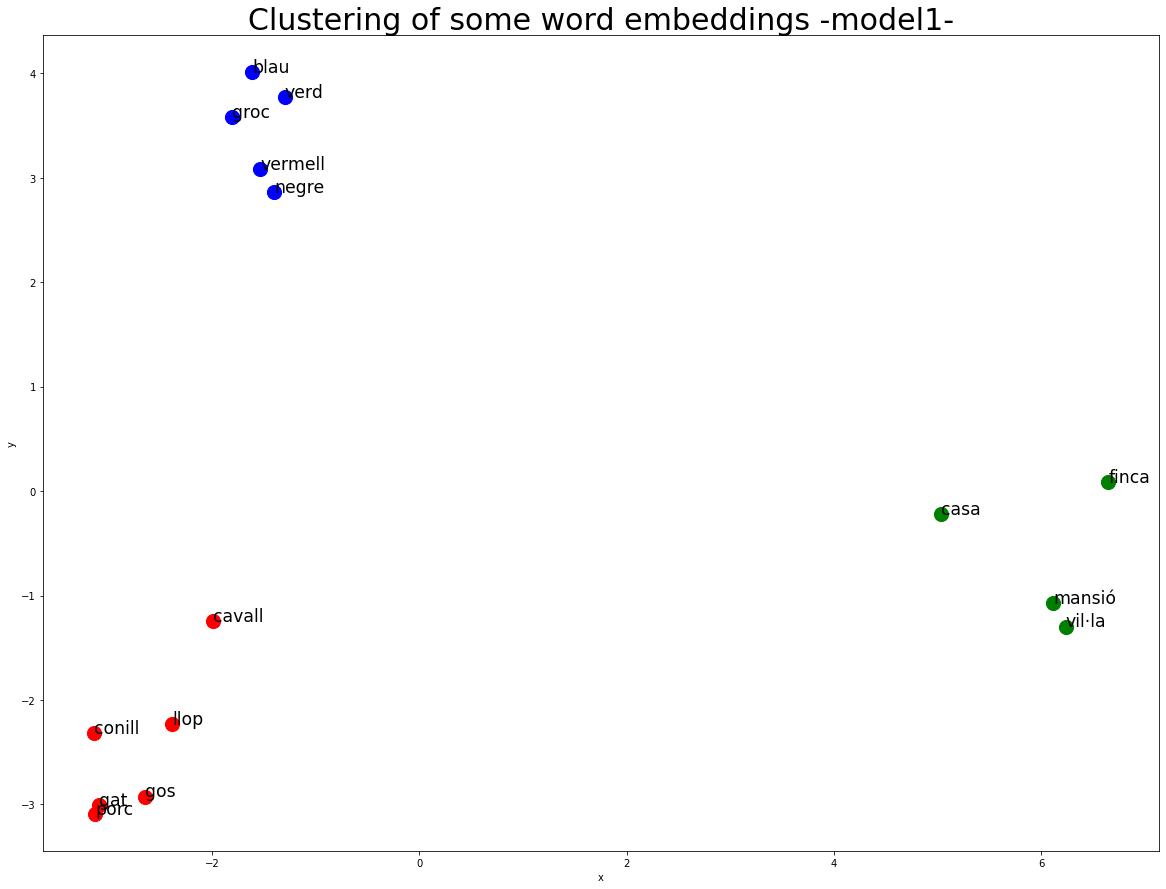

In [28]:
from sklearn.decomposition import PCA
import plotly.express as px

def colouring(i):
    if i <= 5:
        return "red"
    elif i >= 6 and i <= 9:
        return "green"
    else:
        return "blue"

words_to_vis = ["gos", "gat", "llop", "cavall", "conill", "porc", "casa", "finca", "mansió", "vil·la", "groc", "blau", "verd", "negre", "vermell"]

embeddings_matrix_words_to_vis = []
vectors = input_word_vectors

for w in words_to_vis:
    embeddings_matrix_words_to_vis.append(vectors[token_vocab.get_index(w)])

pca = PCA(n_components = 2)
data  = pca.fit_transform(embeddings_matrix_words_to_vis)

plt.figure(figsize = (20,15))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clustering of some word embeddings -model1-', fontsize = 30)
i = 0
for p in data:
    plt.scatter(p[0], p[1], s = 200,  color = colouring(i))
    plt.text(p[0], p[1], words_to_vis[i], fontsize = 'xx-large')
    i = i + 1
plt.show()

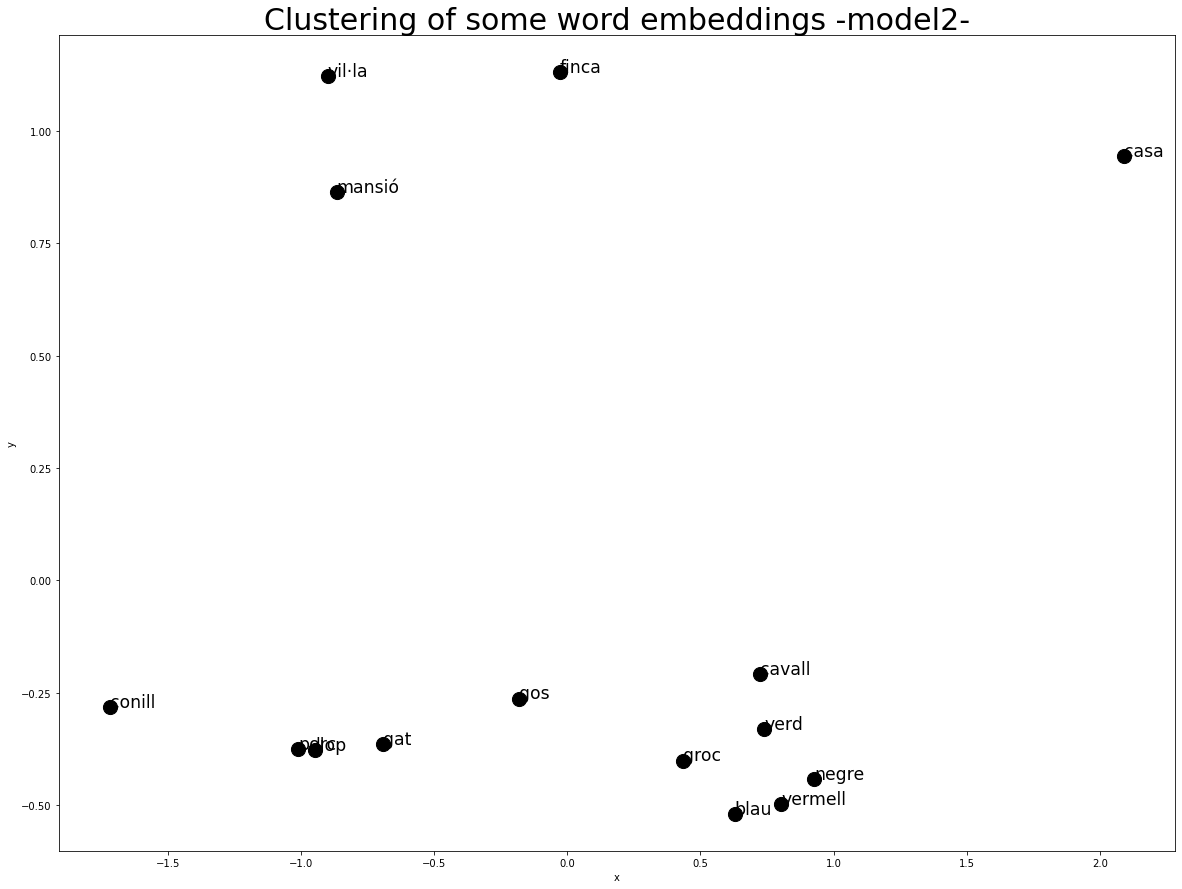

In [27]:
words_to_vis = ["gos", "gat", "llop", "cavall", "conill", "porc", "casa", "finca", "mansió", "vil·la", "groc", "blau", "verd", "negre", "vermell"]

embeddings_matrix_words_to_vis = []
vectors = output_word_vectors

for w in words_to_vis:
    embeddings_matrix_words_to_vis.append(vectors[token_vocab.get_index(w)])

pca = PCA(n_components = 2)
data  = pca.fit_transform(embeddings_matrix_words_to_vis)

plt.figure(figsize = (20,15))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clustering of some word embeddings -model2-', fontsize = 30)
i = 0
for p in data:
    plt.scatter(p[0], p[1], s = 200, color = 'black')
    plt.text(p[0], p[1], words_to_vis[i], fontsize = 'xx-large')
    i = i + 1
plt.show()